In [1]:
%load_ext autoreload
%autoreload 2
!cd `pwd`

In [2]:
from fusus.lakhnawi import Lakhnawi, showString

In [5]:
Lw = Lakhnawi()

In [6]:
Lw.setStyle()

In [7]:
showString("ﳲ")

In [8]:
showString("\ufedf\u064e\u0651")

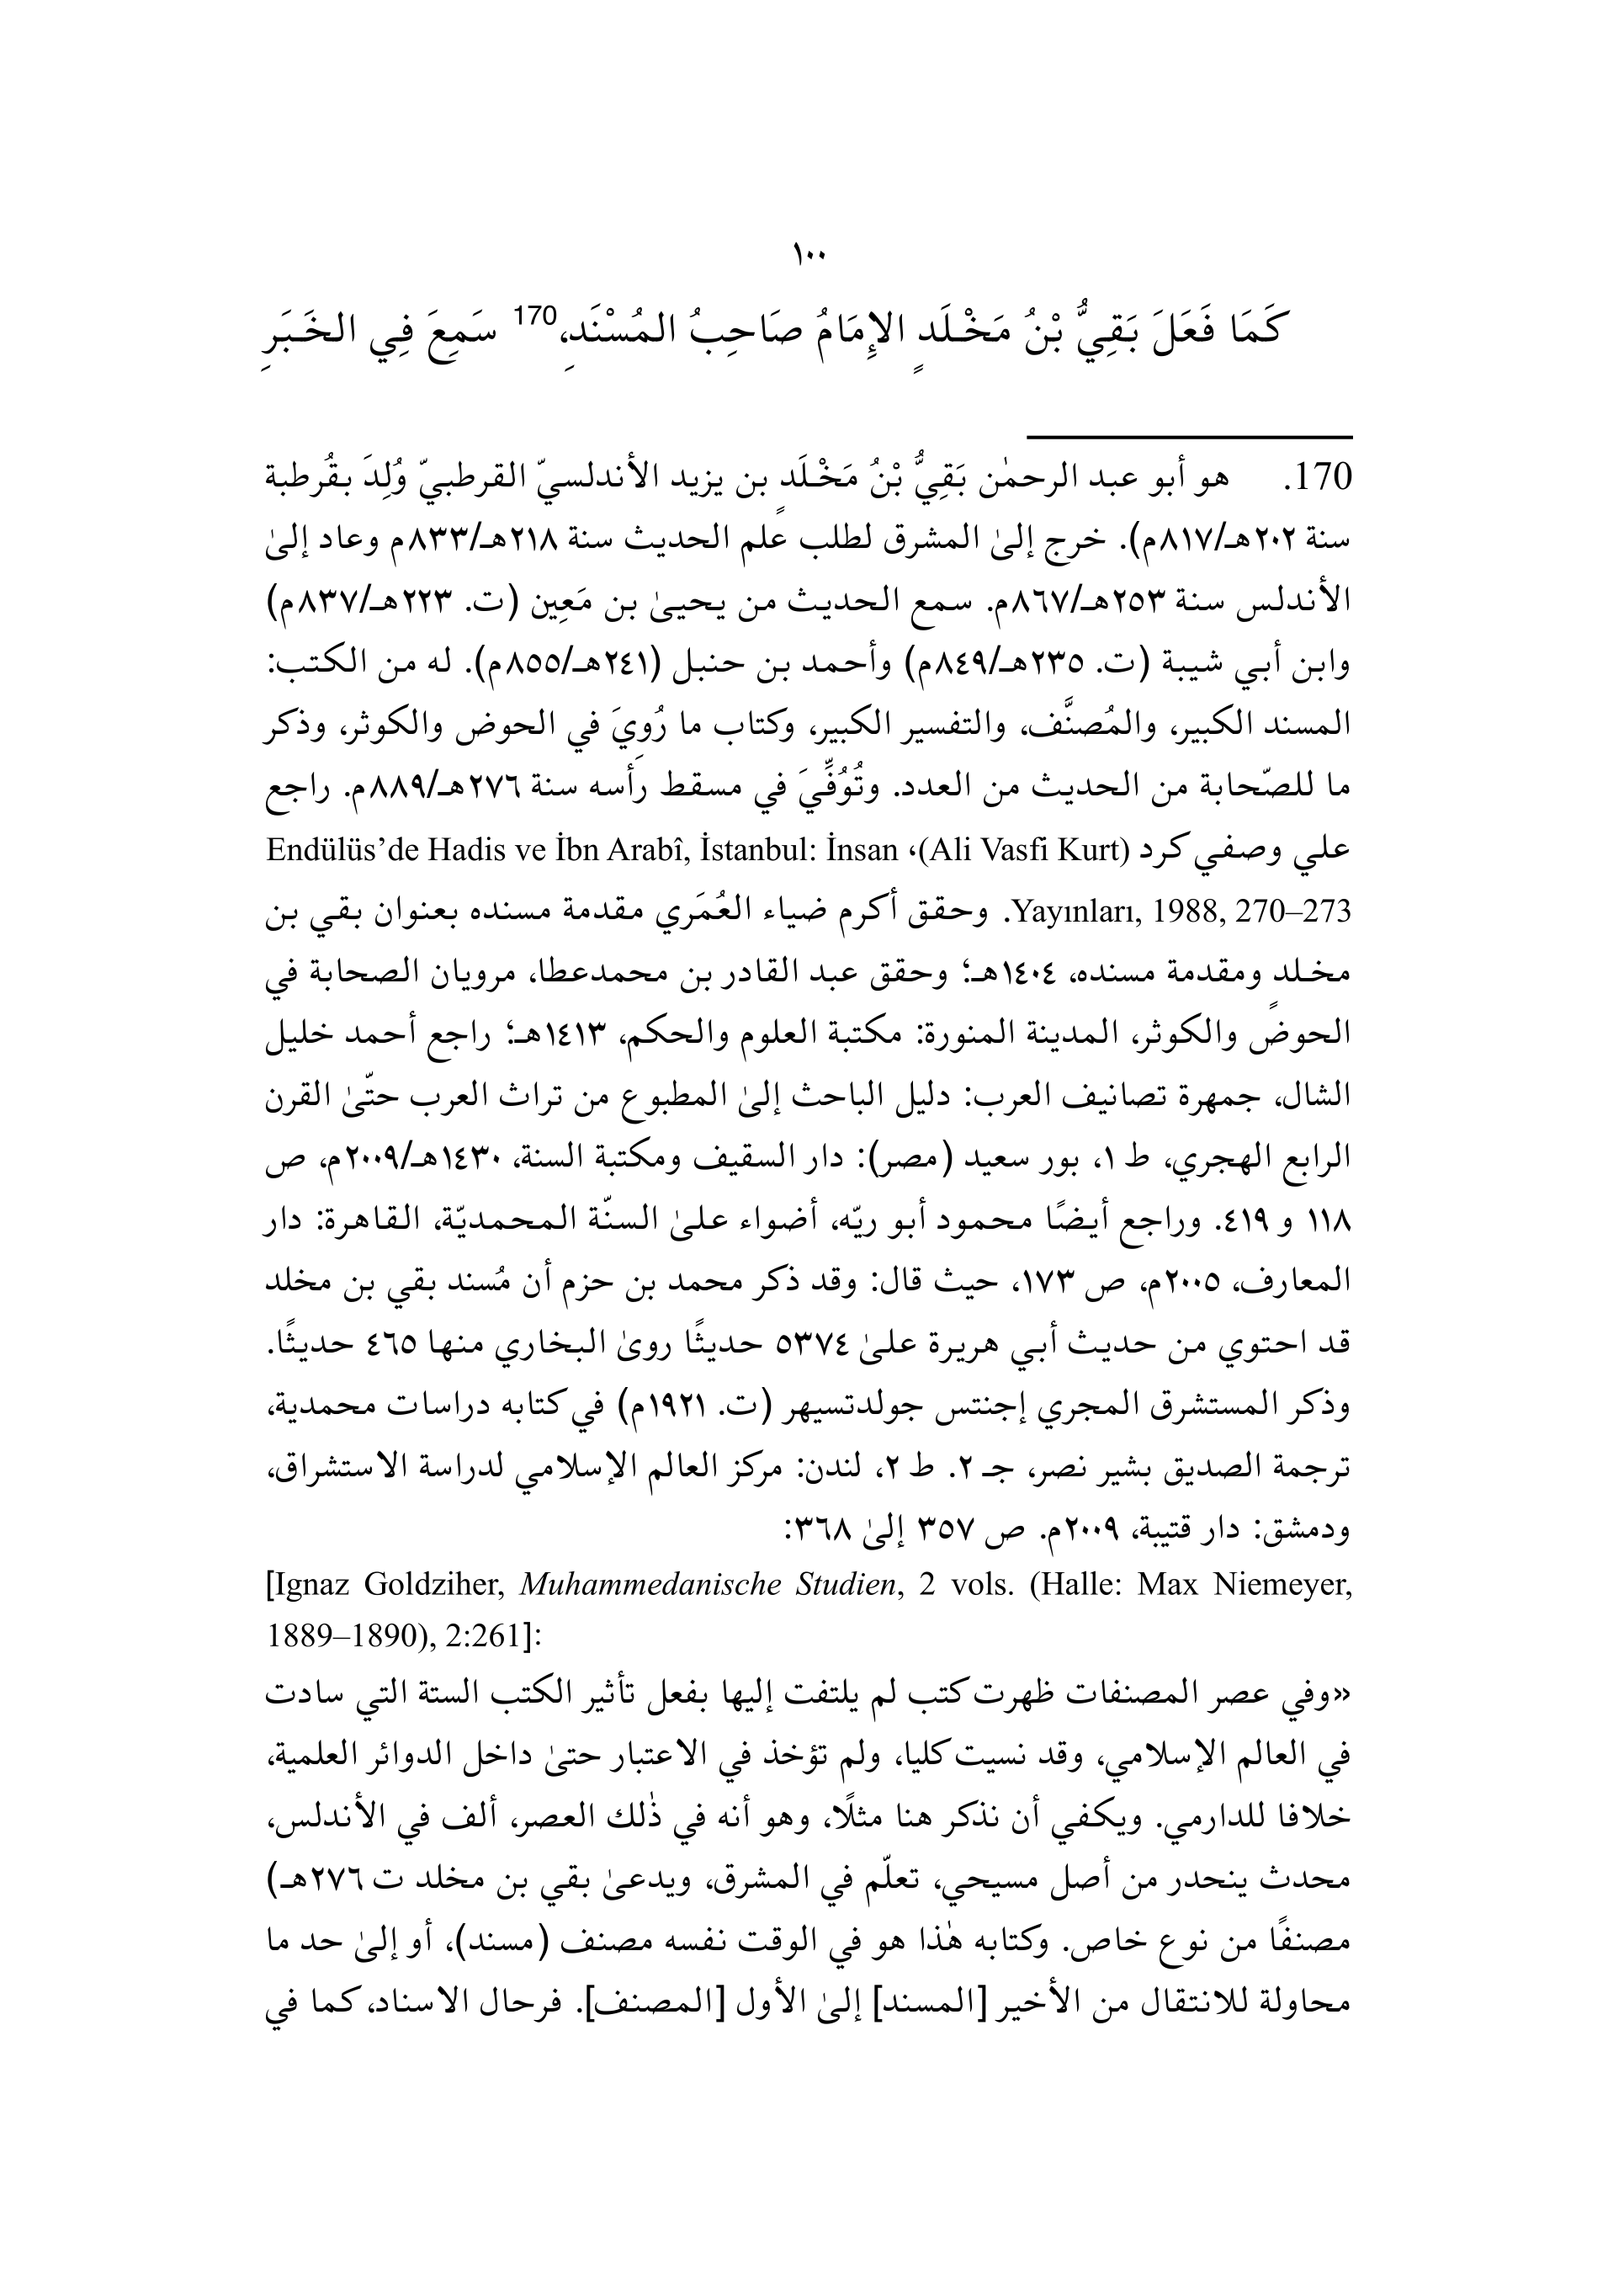

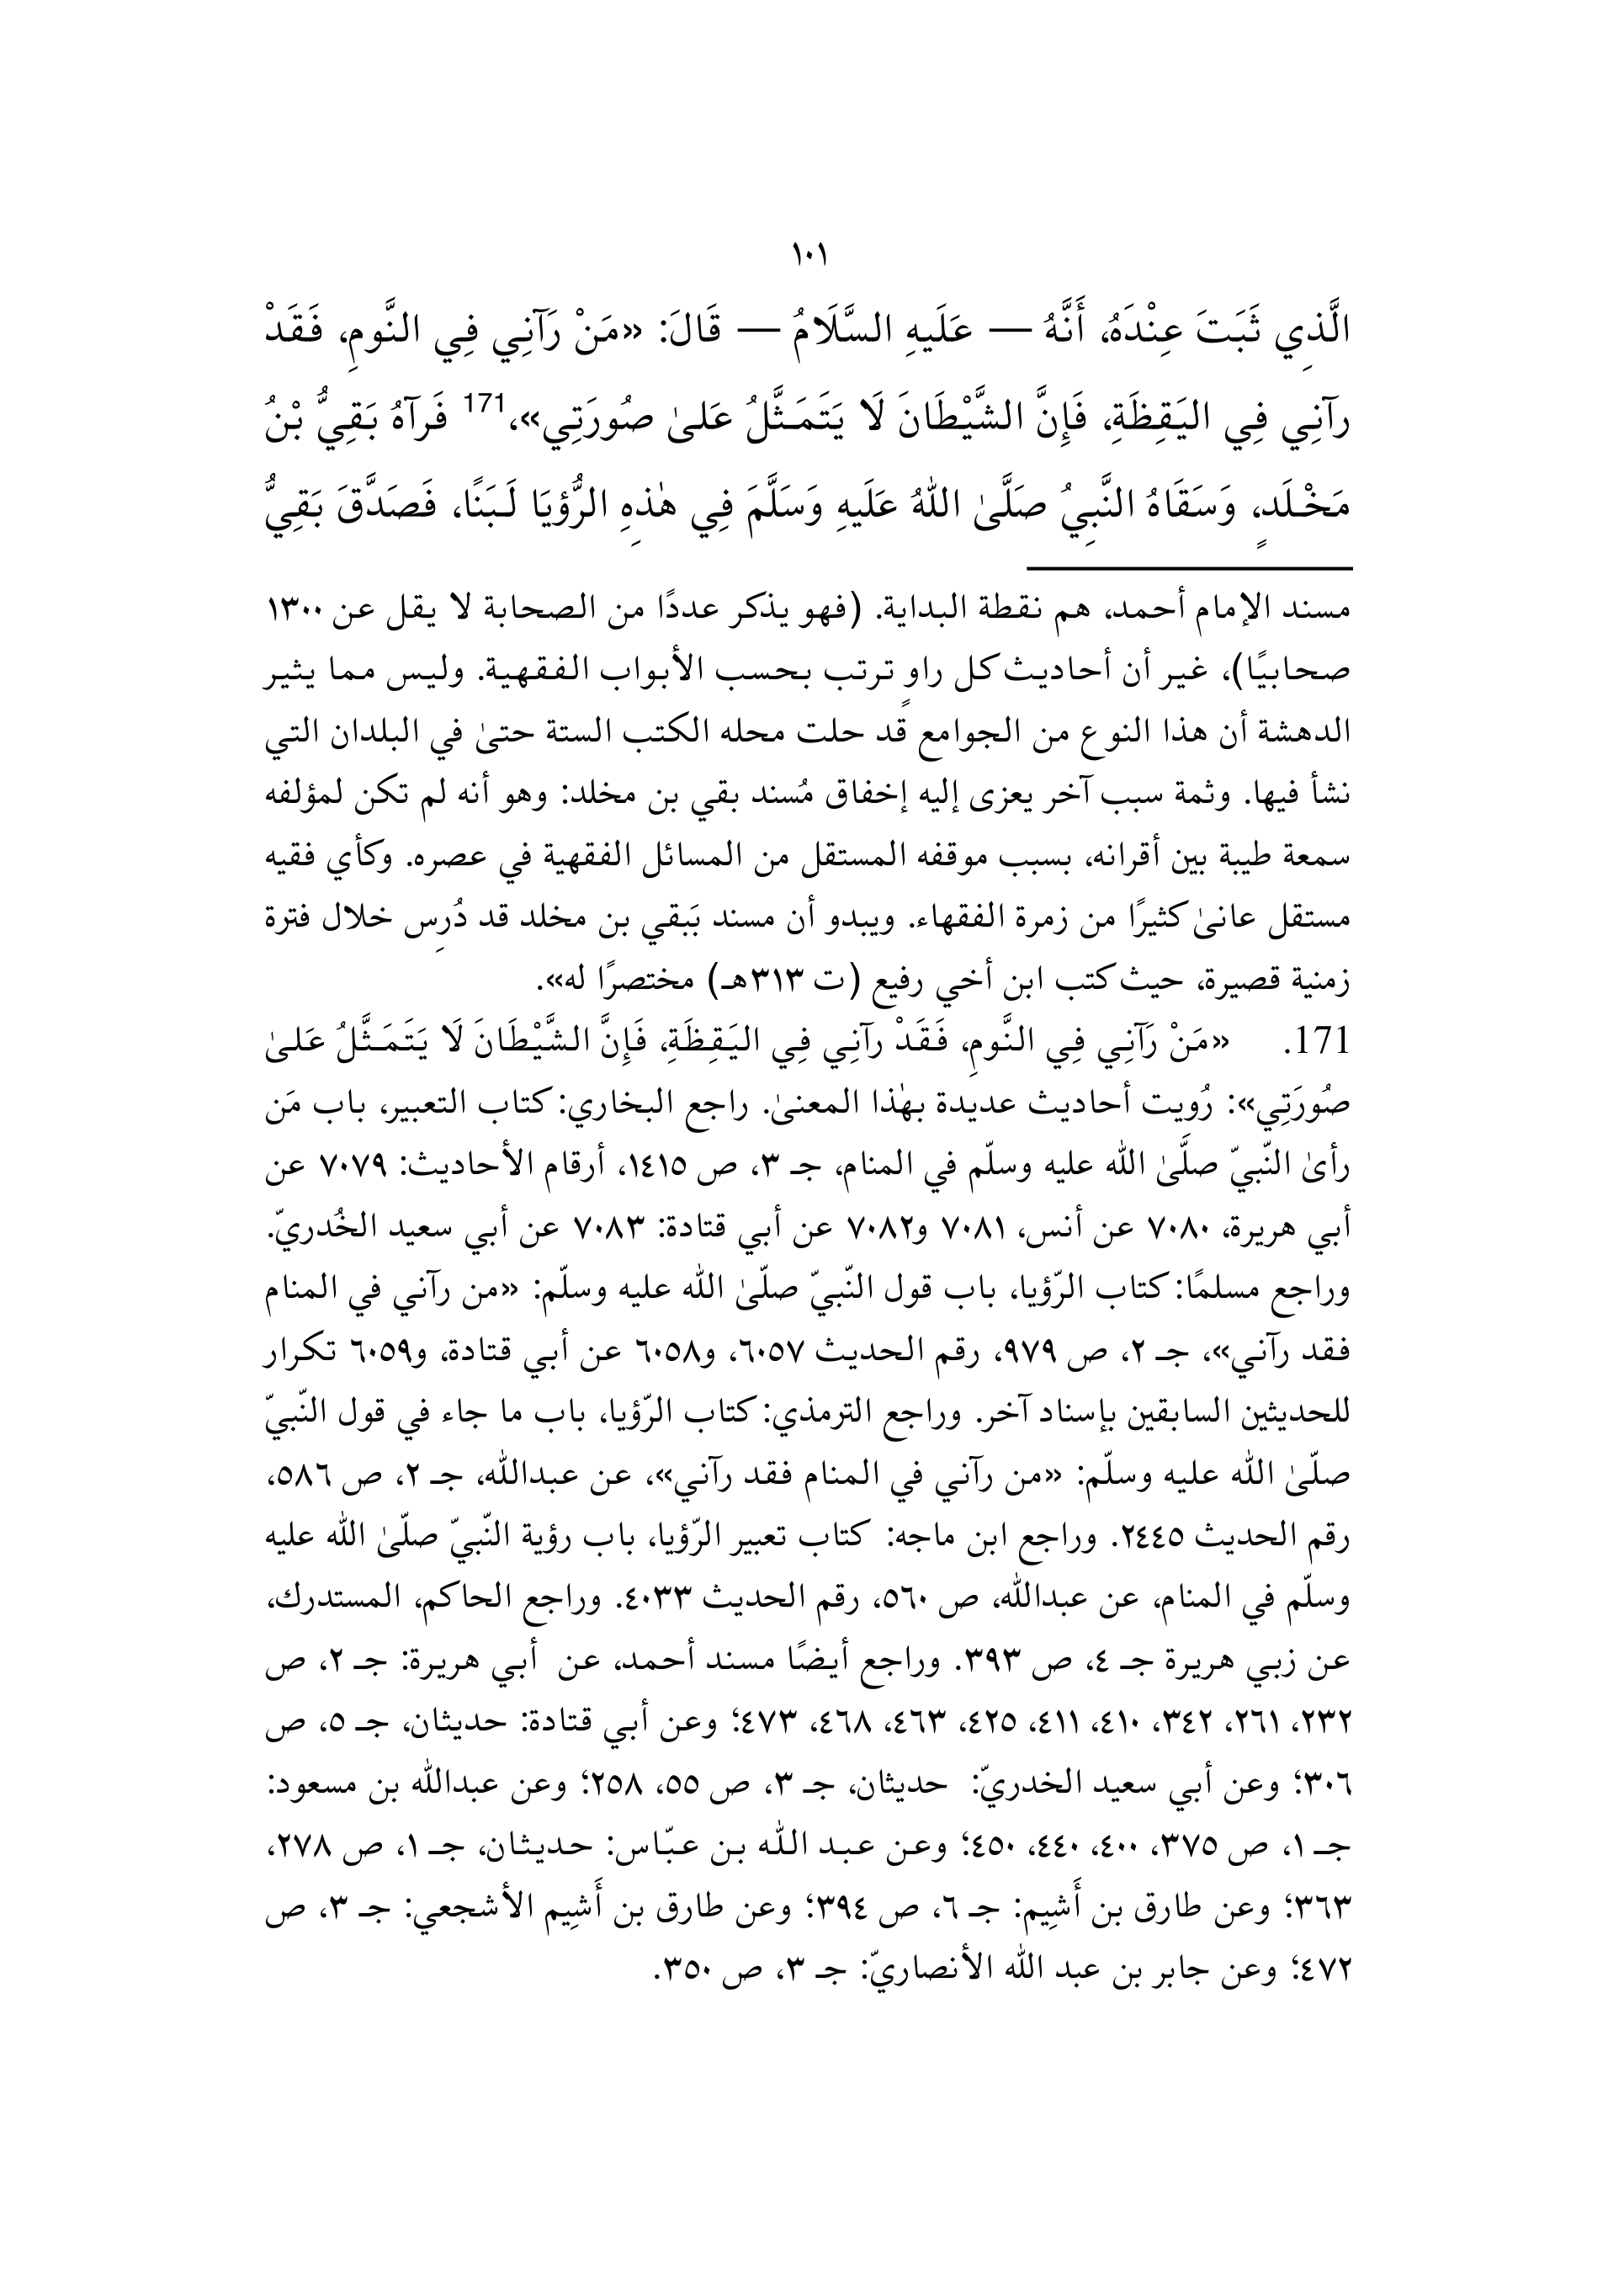

In [9]:
Lw.drawPages("100-101")

In [10]:
Lw.getPages("100-101")

In [11]:
Lw.plainPages("100-101")

٠٠١
ﻛَﻤَﺎﻓَﻌَﻞَﺑَﻘِﻲﺑﻦُﻣَﺨْـﻠَﺪٍاﻻﻣَﺎمُﺻَﺎﺣِﺐ ُاﻟﻤ ُﺴْﻨَﺪ،ِ071ﺳَﻤِﻊَﻓِﻲاﻟﺨ َـﺒَﺮِ
071.ﻫﻮأﺑﻮﻋﺒ ﺪاﻟﺮﺣﻤ ﻦﺑَﻘِﻲﺑﻦُﻣَﺨْـﻠَﺪٍﺑﻦﻳﺰﻳﺪاﻷﻧﺪﻟﺴ ﻲ اﻟﻘ ﺮﻃﺒ ﻲ وُﻟِﺪَﺑﻘ ُﺮﻃﺒ ﺔ
ﺳﻨ ﺔ٢٠٢ﻫـ/٧١٨م(.ﺧﺮجإﻟﲐاﻟﻤ ﺸ ﺮقﻟﻄ ﻠ ﺐﻋﻠ ﻢاﻟﺤ ﺪﻳﺚﺳﻨ ﺔ٨١٢ﻫـ/٣٣٨موﻋﺎدإﻟﲐ
اﻷﻧﺪﻟﺲﺳﻨ ﺔ٣٥٢ﻫـ/٧٦٨م.ﺳﻤ ﻊاﻟﺤ ﺪﻳﺚﻣﻦﻳﺤ ﻴ ﲐﺑﻦﻣَﻌِﲔ)ت.٣٢٢ﻫـ/٧٣٨م(
واﺑﻦأﺑﻲﺷﻴ ﺒ ﺔ)ت.٥٣٢ﻫـ/٩٤٨م(وأﺣﻤ ﺪﺑﻦﺣﻨ ﺒ ﻞ)١٤٢ﻫـ/٥٥٨م(.ﻟﻪﻣﻦاﻟﻜ ﺘ ﺐ:
اﻟﻤ ﺴ ﻨ ﺪاﻟﻜ ﺒ ﻴ ﺮ،واﻟﻤ ُﺼﻨ َّﻒ،واﻟﺘ ﻔ ﺴ ﻴ ﺮاﻟﻜ ﺒ ﻴ ﺮ،وﻛﺘ ﺎبﻣﺎروُيِ َﰲاﻟﺤ ﻮضواﻟﻜ ﻮﺛﺮ،وذﻛﺮ
ﻣﺎﻟﻠ ﺼ ﺤﺎﺑﺔﻣﻦاﻟﺤ ﺪﻳﺚﻣﻦاﻟﻌ ﺪد.وﺗُﻮُﻓﱢﻲ َﰲﻣﺴ ﻘ ﻂرأﺳﻪﺳﻨ ﺔ٦٧٢ﻫـ/٩٨٨م.راﺟﻊ
ﻋﻠ ﻲوﺻﻔ ﻲﻛﺮد)truK ifsaV ilA(،nasnİ :lubnatsİ ,îbarA nbİ ev sidaH ed’sülüdnE
372–072 ,8891 ,ıralnıyaY.وﺣﻘ ﻖأﻛﺮمﺿﻴ ﺎءاﻟﻌ ُﻤَﺮيﻣﻘ ﺪﻣﺔﻣﺴ ﻨ ﺪهﺑﻌ ﻨ ﻮانﺑﻘ ﻲﺑﻦ
ﻣﺨ ـﻠﺪٍوﻣﻘ ﺪﻣﺔﻣﺴ ﻨ ﺪه،٤٠٤١ﻫـ؛وﺣﻘ ﻖﻋﺒ ﺪاﻟﻘ ﺎدرﺑﻦﻣﺤ ﻤ ﺪﻋﻄ ﺎ،ﻣﺮوﻳﺎناﻟﺼ ﺤ ﺎﺑﺔﰲ
اﻟﺤ ﻮضواﻟﻜ ﻮﺛﺮ،اﻟﻤ ﺪﻳﻨ ﺔاﻟﻤ ﻨ ﻮرة:ﻣﻜ ﺘ ﺒ ﺔاﻟﻌ ﻠ ﻮمواﻟﺤ ﻜ ﻢ،٣١٤١ﻫـ؛راﺟﻊأﺣﻤ ﺪﺧﻠ ﻴ ﻞ
اﻟﺸ ﺎل،ﺟﻤ ﻬ ﺮةﺗﺼ ﺎﻧﻴﻒاﻟﻌ ﺮب:دﻟﻴﻞاﻟﺒﺎﺣﺚإﻟﲐاﻟﻤ ﻄ ﺒﻮعﻣﻦﺗﺮاثاﻟﻌ ﺮبﺣﺘّﲐاﻟﻘ ﺮن
اﻟﺮاﺑﻊاﻟﻬ ﺠ ﺮي،ط١،ﺑﻮرﺳﻌ ﻴ ﺪ)ﻣﺼ ﺮ(:داراﻟﺴ ﻘ ﻴ ﻒوﻣﻜ ﺘ ﺒ ﺔاﻟﺴ ﻨ ﺔ،٠٣٤١ﻫـ/٩٠٠٢م،ص
٨١١و٩١٤.وراﺟﻊ

In [12]:
Lw.htmlPages("100-101")

In [13]:
Lw.showInfo("100-101")

11 private use characters in text in 62 occurences on 2 pages
e806: 2 x on 1 page
			page 101:   2 x
e80a: 2 x on 1 page
			page 101:   2 x
e823: 7 x on 2 pages
			page 100:   1 x
			page 101:   6 x
e827: 14 x on 2 pages
			page 100:   3 x
			page 101:  11 x
e82b: 4 x on 2 pages
			page 100:   2 x
			page 101:   2 x
e831: 5 x on 2 pages
			page 100:   2 x
			page 101:   3 x
e833: 10 x on 1 page
			page 101:  10 x
e845: 3 x on 2 pages
			page 100:   1 x
			page 101:   2 x
e8d4: 10 x on 1 page
			page 101:  10 x
e8ea: 2 x on 1 page
			page 100:   2 x
e8eb: 3 x on 2 pages
			page 100:   2 x
			page 101:   1 x
